In [1]:
#Importing Libraries
import wget
import os
import random
import shutil
import zipfile

In [2]:
#Extracting the zip file
local_zip = 'concerete_crack_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

In [12]:
# !pip install scipy==1.2.2

In [6]:
#Renaming all the files in the /training/negative folder as negative

import glob, os

def rename(dir, pattern, titlePattern):
    for pathAndFilename in glob.iglob(os.path.join(dir, pattern)):
        title, ext = os.path.splitext(os.path.basename(pathAndFilename))
        os.rename(pathAndFilename, 
                  os.path.join(dir, titlePattern % title + ext))

rename('concerete_crack_images/training/Negative', r'*.jpg', r'negative(%s)')

In [3]:
#Create a new folder

!mkdir concerete_crack_images/train/
!mkdir concerete_crack_images/val/



In [7]:
#Copying all the files(/training/Positive and /training/Negative into a new folder train)
!cp -a concerete_crack_images/training/Negative/.* concerete_crack_images/train/
!cp -a concerete_crack_images/training/Positive/.* concerete_crack_images/train/

In [9]:
train_data_dir = "concerete_crack_images/train/"

train_imgs = os.listdir(train_data_dir)

test_data_dir = "concerete_crack_images/val/"

In [10]:
#Splits the training data into 80% train and 20% validation
#Randomly copies 20% of the files from the train folder to the val folder 

for f in train_imgs:
    if random.random()>0.8:
        shutil.move(f'{train_data_dir}/{f}',test_data_dir)

In [20]:
train_data_dir = "concerete_crack_images/train/"

train_imgs = os.listdir(train_data_dir)

test_data_dir = "concerete_crack_images/val/"

test_imgs = os.listdir(test_data_dir)

In [16]:
#Number if images in the train and val folder

print(len(train_imgs))
print(len(test_imgs))

25698
6410


In [80]:
import numpy as np
import pandas as pd
import os
#Scipy package contains various functions for multi-dimensional image processing.
from scipy import ndimage 
import scipy
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage import data
import scipy.misc

num_px = 64

def extrcatFeaturesAndLabels(dir, impg_dataset):
  X = np.zeros((len(impg_dataset), num_px*num_px*3))
  y = np.zeros((len(impg_dataset)))
  for i in range(0,len(impg_dataset)) :
    #Read an image from a file as an array.
    #The different colour bands/channels are stored 
    #in the third dimension, such that a 
    #grey-image is MxN, an RGB-image MxNx3 
    image = np.array(mpimg.imread(dir + impg_dataset[i])) 

    resize(image, (100, 100))
       
    # Resize the image. Size of the output image (height, width)
    image = scipy.misc.imresize(image, size=(num_px, num_px)) 
    
    # Convert the matrix to a vector
    image = image.reshape((1, num_px*num_px*3)).T     

    image = image/255.0
    
    image = image.reshape((num_px*num_px*3,1))
    for j in range(0,num_px*num_px*3) :
        X[i][j] = image[j][0]
    
    #If the name of the image is negative, then the value of (y with the targets(label)) will be 1
    if 'negative' in impg_dataset[i]: #train_imgs[i] :
        y[i] = 1
    else :
        y[i] = 0

  y = y.astype(int)
  
  return(X, y)

def get_acuuracy(model, X, y):
  y_pred = model.predict(X)

  if sys.version_info < (3, 0):
      accuracy = ((np.sum(y == y_pred, axis=0)).astype('float') /
            X.shape[0])
  else:
      accuracy = np.sum(y == y_pred, axis=0) / X.shape[0]

  
  
  return(accuracy * 100)

In [21]:
from scipy import ndimage
X_train, y_train = extrcatFeaturesAndLabels(train_data_dir, train_imgs)

/Users/lakshmi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [22]:
X_test, y_test = extrcatFeaturesAndLabels(test_data_dir, test_imgs)

/Users/lakshmi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [23]:
print(X_train.shape)
print(X_test.shape)

(25697, 12288)
(6410, 12288)


In [24]:
print('Training Data set - Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
print('Test Data set - Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Training Data set - Rows: 25697, columns: 12288
Test Data set - Rows: 6410, columns: 12288


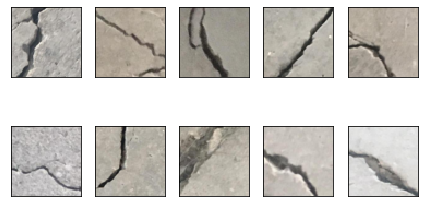

In [25]:
#Displaying images of concerete with cracks

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == 0][i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

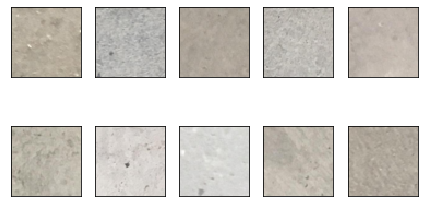

In [26]:
#Displaying images of concerete without cracks
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == 1][i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [27]:
import numpy as np
from scipy.special import expit
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
    n_hidden : int (default: 30)
        Number of hidden units.
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
    epochs : int (default: 500)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    alpha : float (default: 0.0)
        Momentum constant. Factor multiplied with the
        gradient of the previous epoch t-1 to improve
        learning speed
        w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.

        """
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

# Neural Network

In [40]:
nn = NeuralNetMLP(n_output=2, 
                  n_features=X_train.shape[1], 
                  n_hidden=100, 
                  l2=0.1, 
                  l1=0.1, 
                  epochs=1000, 
                  eta=0.001,
                  alpha=0.01,
                  decrease_const=0.00001,
                  minibatches=100, 
                  shuffle=True,
                  random_state=1)

In [41]:
#Fitting the neural network model with 1000 epochs and 100 hidden units
nn.fit(X_train, y_train, print_progress=True)

Epoch: 1000/1000

In [42]:
training_accuracy=get_acuuracy(nn, X_train, y_train)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_acuuracy(nn, X_test, y_test)
print('Test accuracy: %.2f%%' %test_accuracy)

Training accuracy: 90.46%
Test accuracy: 90.15%


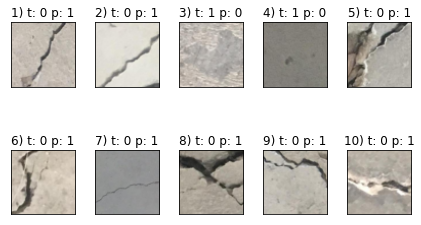

In [45]:
#Misclassified Examples

y_test_pred = nn.predict(X_test)

miscl_img = X_test[y_test != y_test_pred][:10]
correct_lab = y_test[y_test != y_test_pred][:10]
miscl_lab= y_test_pred[y_test != y_test_pred][:10]

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = miscl_img[i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

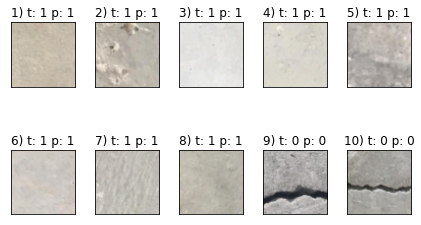

In [46]:
#Correctly Classified Examples

y_test_pred = nn.predict(X_test)

miscl_img = X_test[y_test == y_test_pred][:10]
correct_lab = y_test[y_test == y_test_pred][:10]
miscl_lab= y_test_pred[y_test == y_test_pred][:10]

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = miscl_img[i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import binarize, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [29]:
def encoder(dataset, catFeatures, qtyFeatures):
  dataset = dataset[catFeatures + qtyFeatures]
  dataset_encoded = pd.get_dummies(dataset, 
                                   columns = catFeatures, 
                                   drop_first = True)
  
  return(dataset_encoded)

def plot_auc_curve(model, X, y):
  try:
      y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
  
  auc = roc_auc_score(y, y_pred_prob)
  fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
  
  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title('ROC Curve\n AUC={auc}'.format(auc = auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

def model_training(model, X, y):
  model.fit(X,y)
  
  return(model)

def print_accurcay_metrics(model, X, y, threshold):
  try:
      y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
  y_pred_class = binarize([y_pred_prob], threshold)[0]
  
  print("Accurcay:", accuracy_score(y, y_pred_class))
  print("AUC:", roc_auc_score(y, y_pred_prob))
  print("Log Loss:", log_loss(y, y_pred_prob))
  print("Confusion Matrix:\n", confusion_matrix(y, y_pred_class))
  print("Recall:", recall_score(y, y_pred_class))
  print("Precision:", precision_score(y, y_pred_class))


def Find_Optimal_Cutoff(model, X, y):
  try:
    y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
    
  fpr, tpr, threshold = roc_curve(y, y_pred_prob)
  i = np.arange(len(tpr)) 
  roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
  roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
  
  print("Optimal Cutoff:", roc_t['threshold'].values)
  return(roc_t['threshold'].values)
  
def feature_importance(model, X):
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],
               axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
      print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

# Plot calibration plots
def plot_calibration(y_true, y_prob, n_bins, model_name):
  plt.figure(figsize=(10, 10))
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
  ax2 = plt.subplot2grid((3, 1), (2, 0))

  ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
  fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true, y_prob, n_bins=n_bins)

  ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (model_name, ))

  ax2.hist(y_pred_prob, range=(0, 1), bins=10, label=model_name,
             histtype="step", lw=2)

  ax1.set_ylabel("Fraction of positives")
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc="lower right")
  ax1.set_title('Calibration plots')

  ax2.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  ax2.legend(loc="upper right", ncol=2)

  plt.tight_layout()
  plt.show()

# Random Forest

In [30]:
#Random Forest

rf = RandomForestClassifier(n_estimators=500, 
                            criterion='gini', 
                            max_features='sqrt',
                            n_jobs=-1)
model_training(rf, X_train, y_train)

Find_Optimal_Cutoff(rf, X_test, y_test)
print_accurcay_metrics(rf, X_test, y_test, 0.5)

Optimal Cutoff: [0.458]
Accurcay: 0.98798751950078
AUC: 0.9990627228004874
Log Loss: 0.06465843547803855
Confusion Matrix:
 [[3204   29]
 [  48 3129]]
Recall: 0.9848914069877243
Precision: 0.9908169727675744


In [50]:
training_accuracy=get_acuuracy(rf, X_train, y_train)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_acuuracy(rf, X_test, y_test)
print('Test accuracy: %.2f%%' %test_accuracy)

Training accuracy: 100.00%
Test accuracy: 98.73%


In [66]:
#Copying the file id to csv

import csv
from itertools import zip_longest

d = [pred_imgs]

export_data = zip_longest(*d, fillvalue = '')

with open("concerete_crack_images/predimageid.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerows(export_data)

# Gradient Boosting

In [53]:
#Gradient Boosting

from sklearn.ensemble  import GradientBoostingClassifier

gbt = GradientBoostingClassifier(n_estimators=1000, learning_rate= 0.8,random_state = 0,max_features = 'auto')

model_training(gbt, X_train, y_train)

print("\n********************************")
print("\nTraining Error")
print_accurcay_metrics(gbt, X_train, y_train, 0.5)

print("\n********************************")
print("Test Error")
print_accurcay_metrics(gbt, X_test, y_test, 0.5)


********************************

Training Error
Accurcay: 1.0
AUC: 1.0
Log Loss: 8.268597358281026e-05
Confusion Matrix:
 [[12940     0]
 [    0 12850]]
Recall: 1.0
Precision: 1.0

********************************
Test Error
Accurcay: 0.9813202469526674
AUC: 0.9974874966291775
Log Loss: 0.09504559952250634
Confusion Matrix:
 [[3051   79]
 [  39 3148]]
Recall: 0.9877627863194226
Precision: 0.9755190579485591


In [136]:
# file_path = 'concerete_crack_images/test/.DS_Store'
# os.remove(file_path)

In [121]:
import os

def rename(directory):
    for name in os.listdir(directory):
        prefix = name.split(".png")[0]
        prefix = name.split(".jpg")[0]
        os.rename(os.path.join(directory,name), 
                  os.path.join(directory,prefix + ".jpg"))
     
        
        
path = 'concerete_crack_images/test'
rename(path)

# Getting prediction fr test set using Random Forest

In [122]:
pred_data_dir = "concerete_crack_images/test/"

pred_imgs = os.listdir(pred_data_dir)

In [123]:
#Copying the file id to csv

import csv
from itertools import zip_longest

d = [pred_imgs]

export_data = zip_longest(*d, fillvalue = '')

with open("concerete_crack_images/predimageid.csv","w",newline="") as f:
    writer = csv.writer(f)
    writer.writerows(export_data)

In [111]:
X_pred, y_pred = extrcatFeaturesAndLabels(pred_data_dir, pred_imgs)

In [112]:
Y_pred = rf.predict(X_pred)

In [113]:
np.savetxt('concerete_crack_images/predicted_values.csv',Y_pred)


In [124]:
a = pd.read_csv("concerete_crack_images/predicted_values.csv")
b = pd.read_csv("concerete_crack_images/predimageid.csv")

result = pd.concat([a,b], axis=1,sort=False)

In [125]:
result.to_csv("concerete_crack_images/final_predvalues.csv",index=False)

In [127]:
with open("concerete_crack_images/final_predvalues.csv") as f:
    csv_reader = csv.reader(f)
    with open("RondomForestPrediction.csv", "a") as f:
        csv_writer = csv.writer(f)
        for row in csv_reader:
            if eval(row[0]) == 0:
                csv_writer.writerow(["crack", row[1]])
            else:
                csv_writer.writerow(["intact", row[1]])
        

#  CNN Model

In [130]:
print("Importing libraries...")

import cv2
import numpy as np
import os
import random
import h5py

data_directory = 'concerete_crack_images/training'
img_size = 128
categories = ["Positive", "Negative"]
training_data = []

def create_training_data():
    for category in categories:
        path = os.path.join(data_directory, category)
        class_num = categories.index(category)
        
        # read and resize the images and append to training_data a list with the image itself and its class number
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (img_size, img_size))
            training_data.append([new_array, class_num])

print("Creating training data...")
create_training_data()
print("Training data successfully created!!")

print("Shuffling training data...")
random.shuffle(training_data)
print("Training data successfully shuffled!!")

X_data = []
y = []

# create X with the features (the images) and y with the targets (labels)
for features, label in training_data:
    X_data.append(features)
    y.append(label)

print("X and y data successfully created!!")

# reshape the image to be on the correct format for tensorflow (images, width, height, channels)
print("Reshaping X data...")
X = np.array(X_data).reshape(len(X_data), img_size, img_size, 1)
print("X data successfully reshaped!!")

print("Saving the data...")
hf = h5py.File("concrete_crack_image_data.h5", "w")
hf.create_dataset("X_concrete", data = X, compression = "gzip")
hf.create_dataset("y_concrete", data = y, compression = "gzip")
hf.close()
print("Data successfully saved!!")

Importing libraries...
Creating training data...
Training data successfully created!!
Shuffling training data...
Training data successfully shuffled!!
X and y data successfully created!!
Reshaping X data...
X data successfully reshaped!!
Saving the data...
Data successfully saved!!


In [131]:
print("Importing libraries...")

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import numpy as np
import h5py

img_size = 128

print("Loading the data...")
hf = h5py.File('concrete_crack_image_data.h5', 'r')
X = np.array(hf.get('X_concrete'))
y = np.array(hf.get("y_concrete"))
hf.close()
print("Data successfully loaded!")

print("Scaling the data...!")
X = X / 255
print("Data successfully scaled!")

model = Sequential()

model.add(Conv2D(16, (3, 3), activation = "relu", input_shape = (img_size, img_size, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(.3))

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(.3))

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(.3))

model.add(Flatten())
model.add(Dense(258, activation = "relu"))

model.add(Dense(1, activation = "sigmoid"))

print("Compiling the model...")
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
print("Model successfully compiled!!")

print("Fitting the model...")
model.fit(X, y, batch_size = 64, epochs = 5, validation_split = .2)
print("Model successfully fitted!!")

print("Saving the model...")
model.save("Concrete_Crack_Classification_model.model")
print("Model successfully saved!!")

Importing libraries...
Loading the data...
Data successfully loaded!
Scaling the data...!
Data successfully scaled!
Compiling the model...
Model successfully compiled!!
Fitting the model...
Train on 25685 samples, validate on 6422 samples
Epoch 1/5
25685/25685 [==============================] - 140s 5ms/sample - loss: 0.2973 - accuracy: 0.8315 - val_loss: 0.0752 - val_accuracy: 0.9855
Epoch 2/5
25685/25685 [==============================] - 139s 5ms/sample - loss: 0.0495 - accuracy: 0.9844 - val_loss: 0.0525 - val_accuracy: 0.9868
Epoch 3/5
25685/25685 [==============================] - 139s 5ms/sample - loss: 0.0423 - accuracy: 0.9867 - val_loss: 0.0357 - val_accuracy: 0.9880
Epoch 4/5
25685/25685 [==============================] - 138s 5ms/sample - loss: 0.0336 - accuracy: 0.9896 - val_loss: 0.0333 - val_accuracy: 0.9900
Epoch 5/5
25685/25685 [==============================] - 137s 5ms/sample - loss: 0.0250 - accuracy: 0.9927 - val_loss: 0.0199 - val_accuracy: 0.9941
Model successful

In [132]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_size = 128
img_to_predict = "concerete_crack_images/test" #Insert the path to the image file you want to predict


In [133]:
test_imgs = os.listdir(img_to_predict)

Loading trained model...
Trained model loaded!
Model predicting...
486989533974011.png
[[0.9968593]]


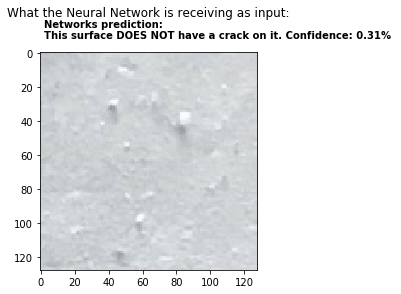

1168548602317220.png
[[0.8741439]]


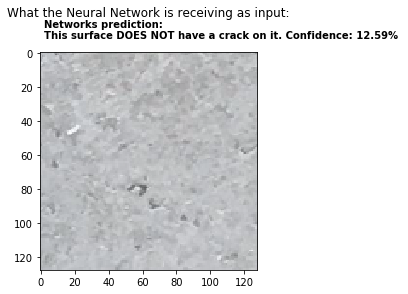

100414884507915.png
[[0.9962913]]


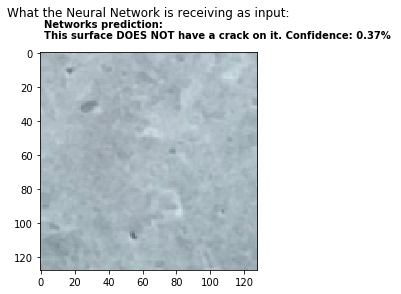

366812315727120.png
[[0.9982084]]


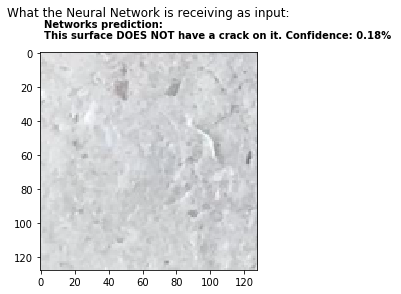

1122086869411936.png
[[0.99876094]]


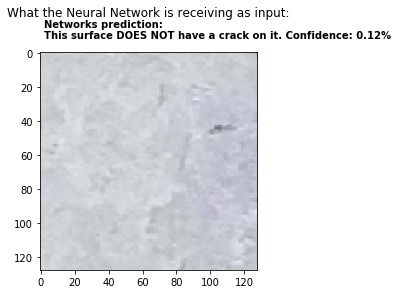

269740654346697.png
[[0.]]


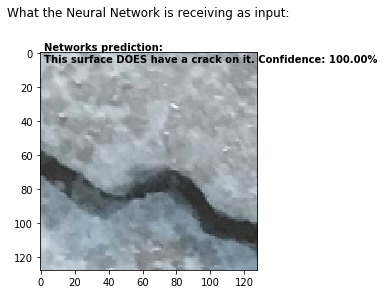

35512860261840.png
[[0.00085759]]


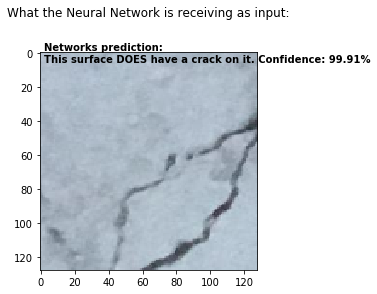

480495035368240.png
[[0.9988268]]


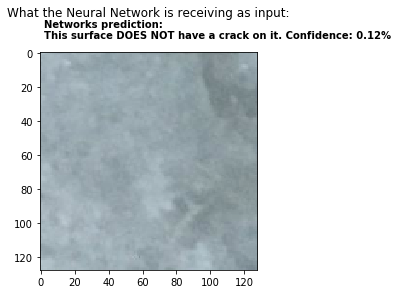

1352335409312034.png
[[0.]]


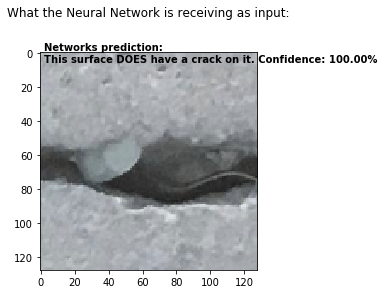

877032173356373.png
[[2.3337254e-06]]


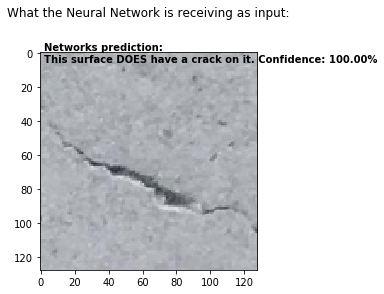

In [134]:
# function to return the correct shape from a image path
def prepare_image(file):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img= img/255.0
    img = cv2.resize(img, (img_size, img_size))
    return img.reshape(-1, img_size, img_size, 1)



print("Loading trained model...")
model = tf.keras.models.load_model("Concrete_Crack_Classification_model.model") 
print("Trained model loaded!")



print("Model predicting...")

for i in range(10):
    print(test_imgs[i])
    prediction = model.predict(prepare_image('concerete_crack_images/test/'+test_imgs[i]))

    # print the prediction based on a 0.5 threshold of the output
    if prediction[0][0] <= .5:
        pred_text = "\nNetworks prediction:\nThis surface DOES have a crack on it. Confidence: {:.2f}%".format((1 - prediction[0][0]) * 100)
    elif prediction[0][0] > .5:
        pred_text = "Networks prediction:\nThis surface DOES NOT have a crack on it. Confidence: {:.2f}% \n\n".format((1 - prediction[0][0]) * 100)
    else:
        print("\nSomething went wrong...")

    print(prediction)

    # display the input image along with the prediction
    plt.imshow(cv2.resize(cv2.imread("concerete_crack_images/test/"+test_imgs[i]), (img_size, img_size)))
    plt.title("What the Neural Network is receiving as input:\n\n")
    plt.text(2, 5, pred_text, fontweight = "bold")
    plt.show()

# Getting prediction for test data using CNN model

In [ ]:
import csv

img_to_predict = "concerete_crack_images/test" #Insert the path to the image file you want to predict
test_imgs = os.listdir(img_to_predict)

# function to return the correct shape from a image path
def prepare_image(file):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img= img/255.0
    img = cv2.resize(img, (img_size, img_size))
    return img.reshape(-1, img_size, img_size, 1)

model = tf.keras.models.load_model("Concrete_Crack_Classification_model.model") 
print("Trained model loaded!")

print("Model predicting...")

for i in range(len(test_imgs)):
    prediction = model.predict(prepare_image('concerete_crack_images/test/'+test_imgs[i]))
    
    # print the prediction based on a 0.5 threshold of the output
    crack_intact = ""
    if prediction[0][0] <= .5:
        pred_text = "\nNetworks prediction:\nThis surface DOES have a crack on it. Confidence: {:.2f}%".format((1 - prediction[0][0]) * 100)
        crack_intact = "crack"
    elif prediction[0][0] > .5:
        pred_text = "Networks prediction:\nThis surface DOES NOT have a crack on it. Confidence: {:.2f}% \n\n".format((1 - prediction[0][0]) * 100)
        crack_intact = "intact"
    else:
        print("\nSomething went wrong...")
    
    # Writing to csv file
    with open('tensor-prediction.csv', 'a') as f:
        csv_writter = csv.writer(f)
        csv_writter.writerow([test_imgs[i], crack_intact])


Trained model loaded!
Model predicting...
